In [1]:
from IPython.display import clear_output
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -f train.csv -p . -c avito-demand-prediction
!unzip train.csv.zip
!rm train.csv.zip
!pip install -qq category_encoders
!pip install -qq transformers
#!pip install -qq ruclip==0.0.2
!pip install -qq pymorphy2
clear_output()

In [2]:
import warnings
warnings.filterwarnings("ignore")
import gc, os, re
from tqdm import tqdm
gc.enable()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import category_encoders as ce

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from gensim.models.doc2vec import Doc2Vec

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop = stopwords.words('russian') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"



```
import ruclip

clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)
predictor = ruclip.Predictor(clip, processor, device, bs=8,)
with torch.no_grad():
    text_latents = predictor.get_text_latents(["создаем текстовые проекции"])
text_latents.shape
```



In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
rubert = AutoModel.from_pretrained("cointegrated/rubert-tiny")

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/241k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/468k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
seed = 42

np.set_printoptions(2)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

In [5]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

In [ ]:
import requests
from pathlib import Path
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
import pymorphy2
from collections import Counter
nltk.download('punkt')


url_stopwords_ru = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt"


def get_text(url, encoding='utf-8', to_lower=True):
    url = str(url)
    if url.startswith('http'):
        r = requests.get(url)
        if not r.ok:
            r.raise_for_status()
        return r.text.lower() if to_lower else r.text
    elif os.path.exists(url):
        with open(url, encoding=encoding) as f:
            return f.read().lower() if to_lower else f.read()
    else:
        raise Exception('parameter [url] can be either URL or a filename')


def normalize_tokens(tokens):
    morph = pymorphy2.MorphAnalyzer()
    return [morph.parse(tok)[0].normal_form for tok in tokens]


def remove_stopwords(tokens, stopwords=None, min_length=4):
    if not stopwords:
        return tokens
    stopwords = set(stopwords)
    tokens = [tok
              for tok in tokens
              if tok not in stopwords and len(tok) >= min_length]
    return tokens


def tokenize_n_lemmatize(
    text, stopwords=None, normalize=True, 
    regexp=r'(?u)\b\w{4,}\b'):
    words = [w for sent in sent_tokenize(text)
             for w in regexp_tokenize(sent, regexp)]
    if normalize:
        words = normalize_tokens(words)
    if stopwords:
        words = remove_stopwords(words, stopwords)
    return words

stopwords_ru = get_text(url_stopwords_ru).splitlines()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    result = result[result["Total"] != 0]
    print(f"Total NA-values = {na.sum()}")
    return result.T

def check_duplicates_and_constants(df_train, df_test=None, threshold=5e-5):
    low_variance_cols = []
    test_exist = True if df_test is not None else False
    print(f"Initial train shape: {df_train.shape}")
    if test_exist:
        print(f"Initial test shape: {df_test.shape}")

    print(f"Duplicates in train: {df_train.duplicated().sum()}")
    if test_exist:
        print(f"Duplicates in test: {df_test.duplicated().sum()}")

    df_train.drop_duplicates(inplace=True)
    for column in df_train.columns:
        if df_train[column].nunique() < 2:
            end_phrase = "both from train and test sets" if test_exist else "from train set"
            print(f"{column} in train set is constant, removed {end_phrase}.")
            df_train.drop(column, axis=1, inplace=True)
            if test_exist:
                df_test.drop(column, axis=1, inplace=True)
        elif df_train[column].nunique() < 20:
            freqs = df_train[column].value_counts(dropna=True)
            freqs /= len(df_train)
            if freqs.iloc[1] < threshold:
                low_variance_cols.append(column)

    print(f"Final train shape: {df_train.shape}", end=' ')
    if test_exist:
        print(f", test shape: {df_test.shape}.")
    if len(low_variance_cols) > 0:
        print("Check next columns for usability: ", *low_variance_cols)
    if test_exist:
        return df_train, df_test
    else:
        return df_train

def preprocessor(text, stop=None):
    text = text.lower()
    text = re.sub('<[^>]*>', '', text)
    text = re.sub('[\W]+', ' ', text)
    text = re.sub(' +', ' ', text)
    if stop is not None:
        text = " ".join([w for w in text.split() if w not in stop])
    return text.rstrip()

def embed_bert(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]  # CLS token
    embeddings = nn.functional.normalize(embeddings)
    return embeddings[0]

In [7]:
data = pd.read_csv("train.csv", parse_dates=["activation_date"], index_col="item_id", usecols=["item_id", "region", "parent_category_name", "description", "price", "user_type", "param_1", "city",
                                                                                               "item_seq_number", "activation_date", "image_top_1", "deal_probability"])  # category_name?
# user_id may be also useful as users on avito have ratings. User id with low rating has lower probability to sell goods

In [8]:
data.head()

,region,city,parent_category_name,param_1,description,price,item_seq_number,activation_date,user_type,image_top_1,deal_probability
item_id,,,,,,,,,,,
b912c3c6a6ad,Свердловская область,Екатеринбург,Личные вещи,Постельные принадлежности,"Кокон для сна малыша,пользовались меньше месяц...",400.0000,2,2017-03-28,Private,1008.0000,0.1279
2dac0150717d,Самарская область,Самара,Для дома и дачи,Другое,"Стойка для одежды, под вешалки. С бутика.",3000.0000,19,2017-03-26,Private,692.0000,0.0000
ba83aefab5dc,Ростовская область,Ростов-на-Дону,Бытовая электроника,"Видео, DVD и Blu-ray плееры","В хорошем состоянии, домашний кинотеатр с blu ...",4000.0000,9,2017-03-20,Private,3032.0000,0.4318
02996f1dd2ea,Татарстан,Набережные Челны,Личные вещи,Автомобильные кресла,Продам кресло от0-25кг,2200.0000,286,2017-03-25,Company,796.0000,0.8032
7c90be56d2ab,Волгоградская область,Волгоград,Транспорт,С пробегом,Все вопросы по телефону.,40000.0000,3,2017-03-16,Private,2264.0000,0.2080


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1503424 entries, b912c3c6a6ad to 9ad3b7bff1db
Data columns (total 11 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   region                1503424 non-null  object        
 1   city                  1503424 non-null  object        
 2   parent_category_name  1503424 non-null  object        
 3   param_1               1441848 non-null  object        
 4   description           1387148 non-null  object        
 5   price                 1418062 non-null  float64       
 6   item_seq_number       1503424 non-null  int64         
 7   activation_date       1503424 non-null  datetime64[ns]
 8   user_type             1503424 non-null  object        
 9   image_top_1           1390836 non-null  float64       
 10  deal_probability      1503424 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 137.6+ MB


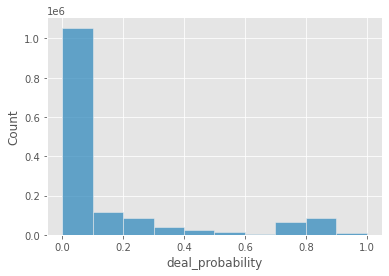

In [ ]:
sns.histplot(data["deal_probability"], bins=10)
plt.show()

In [9]:
class RMSE(nn.Module):
    def __init__(self):
        super(RMSE, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [10]:
data = check_duplicates_and_constants(data)

Initial train shape: (1503424, 11)
Duplicates in train: 18
Final train shape: (1503406, 11) 

In [11]:
check_missings(data)  # for boosting we may assume not filling nans to split them by min or max, here we can just drop nans

Total NA-values = 375785


,param_1,description,price,image_top_1
Total,61576,116260,85362,112587
Percent,4.0958,7.7331,5.6779,7.4888
Types,object,object,float64,float64


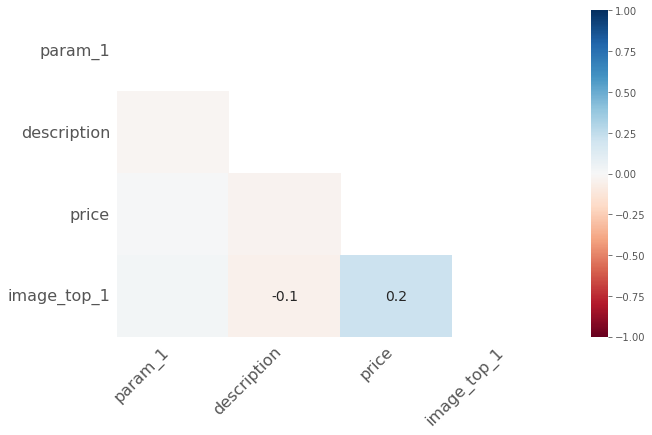

In [ ]:
missingno.heatmap(data, figsize=(10, 6))

In [12]:
data.dropna(inplace=True)

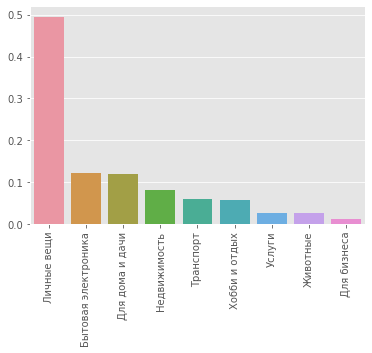

In [ ]:
parent_counts = data.parent_category_name.value_counts(normalize=True)

sns.barplot(x=parent_counts.index, y=parent_counts.values)
plt.xticks(rotation=90)
plt.show()

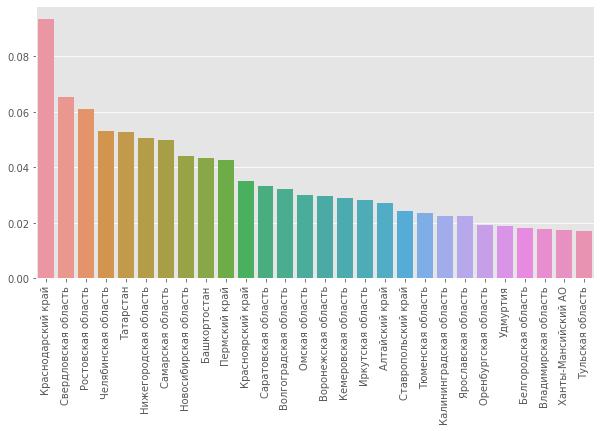

In [ ]:
region = data.region.value_counts(normalize=True)
plt.figure(figsize=(10, 5))
sns.barplot(x=region.index, y=region.values)
plt.xticks(rotation=90)
plt.show()

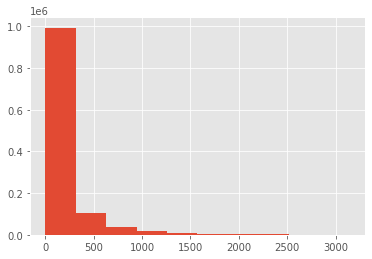

In [ ]:
data.description.str.len().hist()

In [ ]:
data.describe()  # outliers: iqr, percentile clipping?

,price,item_seq_number,image_top_1,deal_probability
count,1221635.0000,1221635.0000,1221635.0000,1221635.0000
mean,260599.4812,866.3180,1247.7858,0.1368
std,4195423.8619,6076.2236,974.1476,0.2630
min,0.0000,1.0000,0.0000,0.0000
25%,500.0000,10.0000,425.0000,0.0000
50%,1400.0000,32.0000,1071.0000,0.0000
75%,7000.0000,100.0000,2218.0000,0.1299
max,2000025000.0000,204429.0000,3066.0000,1.0000


In [ ]:
data.describe(exclude="number") 

,region,parent_category_name,description,activation_date,user_type
count,1221635,1221635,1221635,1221635,1221635
unique,28,9,1157109,19,3
top,Краснодарский край,Личные вещи,В хорошем состоянии,2017-03-27 00:00:00,Private
freq,114103,604522,2185,93352,856965
first,NaN,NaN,NaN,2017-03-15 00:00:00,NaN
last,NaN,NaN,NaN,2017-04-03 00:00:00,NaN


In [ ]:
data.activation_date.min(), data.activation_date.max()  # small delta, so splitting by time is unneccessary

(Timestamp('2017-03-15 00:00:00'), Timestamp('2017-04-03 00:00:00'))

In [13]:
condition = (data.price > np.percentile(data.price, 99.99)) & (data.parent_category_name == "Недвижимость")  # check by category
data[condition].sort_values("price", ascending=False).head(10)

,region,city,parent_category_name,param_1,description,price,item_seq_number,activation_date,user_type,image_top_1,deal_probability
item_id,,,,,,,,,,,
6df9bb4c6120,Краснодарский край,Белореченск,Недвижимость,Продам,Хорошая чистая квартира. Тихий район. Имеется ...,1170000000.0000,22,2017-03-20,Company,2220.0000,0.0000
389de1e3c386,Краснодарский край,Туапсе,Недвижимость,Продам,Продаётся земельный участок в с.Ольгинка Туапс...,1100000000.0000,261,2017-03-24,Company,1694.0000,0.0000
7de3136be119,Краснодарский край,Краснодар,Недвижимость,Продам,Продается действующай торговый центр с арендат...,1000000000.0000,47160,2017-03-27,Shop,2280.0000,0.0684
8010077f857d,Самарская область,Тольятти,Недвижимость,Продам,ХАРАКТЕРИСТИКА ОБЪЕКТА/\n /\nОбъект – здание у...,652400000.0000,62,2017-03-16,Shop,2218.0000,0.0000
e4c27e48bd61,Ставропольский край,Ставрополь,Недвижимость,Продам,"Участок 14га, собственность, все центральные к...",630000000.0000,290,2017-03-27,Company,1610.0000,0.2472
252fe752daaf,Краснодарский край,Сочи,Недвижимость,Продам,подробности по запросу,589540000.0000,35796,2017-03-15,Company,1698.0000,0.0857
fce21a488c96,Краснодарский край,Сочи,Недвижимость,Продам,"Продаю участок в Красной Поляне 3.2гектара, на...",500000000.0000,93,2017-03-27,Company,1317.0000,0.0510
0b506337759f,Краснодарский край,Сочи,Недвижимость,Продам,Предлагается к продаже земельный участок в Эли...,500000000.0000,66,2017-03-27,Company,2218.0000,0.0000
772e674791d3,Краснодарский край,Сочи,Недвижимость,Продам,"Продаю участок в красной поляне 5 гектар, нахо...",500000000.0000,94,2017-03-27,Company,2280.0000,0.0857


In [14]:
data.drop("6df9bb4c6120", inplace=True)  # extremely expensive flat

In [15]:
for category in data.parent_category_name.unique():
    # iqr, percentile or drop: drop
    prior = (data.parent_category_name == category)
    percentile = np.percentile(data.loc[data.parent_category_name == category, "price"], 99.99)
    condition = (data.price > percentile) & prior  # only extreme values dropped
    data = data[~condition]

data.shape

(1172999, 11)

In [ ]:
# adversarial check is too computationally expensive: split with parent type - region stratification

In [19]:
data["day"] = data.activation_date.dt.day.astype("int")
data["weekday"] = data.activation_date.dt.weekday.astype("int")

data.drop("activation_date", axis=1, inplace=True)

In [ ]:
region_encoder = LabelEncoder()
param_encoder = LabelEncoder()

parent_encoder = LabelEncoder()
city_encoder = LabelEncoder()

data["region"] = region_encoder.fit_transform(data["region"])
data["param_1"] = param_encoder.fit_transform(data["param_1"])
data["city"] = city_encoder.fit_transform(data["city"])
data["parent_category_name"] = parent_encoder.fit_transform(data["parent_category_name"])

In [ ]:
# clean text from redundant punctuation and symbols
data["description"] = data["description"].apply(preprocessor)  # stop False if ruclip: to preserve context

In [ ]:
data = pd.get_dummies(data, columns=["user_type"], drop_first=True)

In [ ]:
data["strat"] = LabelEncoder().fit_transform(data["parent_category_name"].astype("str") + data["region"].astype("str")).astype("float")

x_train, x_valid = train_test_split(data, train_size=1_000_000, stratify=data["strat"], random_state=seed)
x_valid, x_test = train_test_split(x_valid, train_size=100_000, stratify=x_valid["strat"], random_state=seed)
del data; gc.collect()
x_train.drop("strat", axis=1, inplace=True)
x_valid.drop("strat", axis=1, inplace=True)
x_test.drop("strat", axis=1, inplace=True)

x_train.shape, x_valid.shape, x_test.shape

((1000000, 13), (100000, 13), (72999, 13))

In [ ]:
city_parent_mean = x_train.groupby(["city", "parent_category_name"])["price"].mean().reset_index().rename(columns={"price": "city_parent_price"})

In [ ]:
x_train = x_train.merge(city_parent_mean, on=["city", "parent_category_name"], how="left")
x_valid = x_valid.merge(city_parent_mean, on=["city", "parent_category_name"], how="left")
x_test = x_test.merge(city_parent_mean, on=["city", "parent_category_name"], how="left")  # join is faster

x_valid["city_parent_price"].fillna(x_train["city_parent_price"].mean(), inplace=True)
x_test["city_parent_price"].fillna(x_train["city_parent_price"].mean(), inplace=True)

del city_parent_mean; gc.collect()

0

In [ ]:
# target_encoder = ce.cat_boost.CatBoostEncoder(random_state=seed)  # or practically may be better to add them as embeddings also

# x_train[["parent_category_name", "city"]] = target_encoder.fit_transform(x_train[["parent_category_name", "city"]], x_train["deal_probability"])
# x_valid[["parent_category_name", "city"]] = target_encoder.transform(x_valid[["parent_category_name", "city"]])
# x_test[["parent_category_name", "city"]] = target_encoder.transform(x_test[["parent_category_name", "city"]])

In [ ]:
columns_to_scale = ["price", "item_seq_number", "image_top_1", "city_parent_price"]

scaler = StandardScaler()  # or MinMaxScaler to scale in range [0,1], which is closer to catboost encodings

x_train[columns_to_scale] = scaler.fit_transform(x_train[columns_to_scale])
x_valid[columns_to_scale] = scaler.transform(x_valid[columns_to_scale])
x_test[columns_to_scale] = scaler.transform(x_test[columns_to_scale])

# 
# if using TabNet: just skip until corresponding chapter III
#

In [ ]:
region_embed_dim = x_train.region.nunique()
param_embed_dim = x_train.param_1.nunique()
day_embed_dim = x_train.day.nunique()
weekday_embed_dim = x_train.weekday.nunique()

In [ ]:
def read_corpus(series, tokens_only=False):
    for i, tokens in enumerate(series):
        tokens = gensim.utils.simple_preprocess(tokens)
        if tokens_only:
            yield tokens
        else:
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

# train_corpus = list(read_corpus(x_train["description"]))

# dmodel = Doc2Vec(vector_size=50, min_count=2, epochs=20, window=10, hs=0, negative=10, alpha=0.03, min_alpha=0.0007, seed=seed)
# dmodel.build_vocab(train_corpus)

# dmodel.train(train_corpus, total_examples=dmodel.corpus_count, epochs=dmodel.epochs)

In [ ]:
class DemandDataset(Dataset):
    def __init__(self, data):
        data = data.copy(deep=True)
        self.data = data.reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, ix):
        row = self.data.loc[ix].squeeze()
        numerical = row[["price", "item_seq_number", "image_top_1", "city_parent_price", "user_type_Private", "user_type_Shop"]].values.astype(np.float32)
        numerical = torch.as_tensor(numerical, dtype=torch.float32)
        region = torch.as_tensor(row["region"], dtype=torch.int32)
        param = torch.as_tensor(row["param_1"], dtype=torch.int32)
        day = torch.as_tensor(row["day"], dtype=torch.int32)
        weekday = torch.as_tensor(row["weekday"], dtype=torch.int32)
        city = torch.as_tensor(row["city"], dtype=torch.int32)
        parent = torch.as_tensor(row["parent_category_name"], dtype=torch.int32)

        target = torch.as_tensor(row["deal_probability"], dtype=torch.float32)
        # ruclip
        # with torch.no_grad():
        #     description = predictor.get_text_latents([row["description"][:500]]).squeeze(0)  # reduce number of tokens as 0.9 quantile = 489 words
        description = embed_bert(row["description"][:500], rubert, tokenizer)  # [312]
        return numerical, region, param, day, weekday, description, city, parent, target

In [ ]:
train_ds = DemandDataset(x_train)
valid_ds = DemandDataset(x_valid)
test_ds = DemandDataset(x_test)

train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=256, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False)

In [ ]:
class ResidualBlock(nn.Module):
    """ Almost classic residual block: x + fn(x) or g(x) + f(x) """
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.activation = nn.ReLU()
        self.layer1 = nn.Sequential(
                            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                            nn.BatchNorm1d(out_channels),
                            nn.ReLU()
                )
        self.layer2 = nn.Sequential(
                            nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm1d(out_channels)
                )
        if in_channels != out_channels or stride != 1:
            self.downsample = nn.Sequential(
                                    nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                                    nn.BatchNorm1d(out_channels),
                    )
        else:
            self.downsample = None
        self.dropout = nn.Dropout(p=dropout)
            
    def forward(self, x):
        residual = x
        x = self.layer1(x)
        x = self.layer2(x)
        if self.downsample is not None:
            residual = self.downsample(residual)
        x = x + residual
        x = self.activation(x)
        x = self.dropout(x)

        return x

In [ ]:
class ResidualBlock_(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=1, stride=1, padding=0, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.layer1 = nn.Sequential(
                            nn.Conv1d(in_channels, out_channels, kernel, stride, padding=padding),  # stride=2
                            nn.BatchNorm1d(out_channels),
                            nn.ReLU(),
                            )
        self.layer2 = nn.Sequential(
                            nn.Conv1d(out_channels, out_channels, kernel, stride, padding=padding),  # stride=1
                            nn.BatchNorm1d(out_channels),
                            )
        if in_channels != out_channels:  # assuming kernel = 1
            self.residual = nn.Sequential(
                                nn.Conv1d(in_channels, out_channels, kernel, stride, padding=padding),  # stride=2
                                nn.BatchNorm1d(out_channels),
                                )
        else:
            self.residual = None
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        residual = x
        out = self.layer1(x)
        out = self.layer2(out)
        if self.residual is not None:
            residual = self.residual(residual)  # as we are changing no of channels (resnet: in=out, in!=out+downsample)
        out = out + residual
        out = self.activation(out)
        out = self.dropout(out)
        return out

class DemandModel(nn.Module):
    def __init__(self,
                 in_channels=1,
                 out_channels=4,  # 32
                 num_blocks=4,
                 total_dim=386, 
                 region_embed_dim=region_embed_dim, 
                 param_embed_dim=param_embed_dim, 
                 day_embed_dim=31, 
                 weekday_embed_dim=7, 
                 city_dim=1692,
                 parent_dim=9,
                 dropout=0.1):
        super(DemandModel, self).__init__()
        self.region_emb = nn.Embedding(region_embed_dim, 10)
        self.param_emb = nn.Embedding(param_embed_dim, 32)
        self.day_emb = nn.Embedding(day_embed_dim, 6)
        self.weekday_emb = nn.Embedding(weekday_embed_dim, 2)
        self.city_emb = nn.Embedding(city_dim, 16)
        self.parent_emb = nn.Embedding(parent_dim, 2)

        self.dropout = nn.Dropout(p=dropout)
        self.activation = nn.ReLU()
        """
        layers = []
        for _ in range(num_blocks):
            layers.extend([
                    nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                    nn.BatchNorm1d(out_channels),
                    nn.ReLU(),
                    nn.Dropout(p=dropout),
            ])
            in_channels = out_channels
            out_channels = out_channels // 2
        self.conv = nn.Sequential(*layers)
        """
        self.projection = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),  # in_channels, in_channels
            nn.BatchNorm1d(out_channels),  # in_channels
            nn.ReLU(),
            nn.Dropout(p=dropout),
            )
        layers = []
        in_channels = out_channels
        for _ in range(num_blocks):
            layers.extend([
                    ResidualBlock(in_channels, in_channels, stride=1),
                    ResidualBlock(in_channels, out_channels, stride=2),  # stride=1
                ])
            in_channels = out_channels  # in_channels = out_channels
            out_channels *= 2  # out_channels = out_channels // 2
        self.residuals = nn.Sequential(*layers)
        
        in_channels = (out_channels // 2) * 25  # total_dim
        self.pool = nn.AvgPool1d(2)
        self.batch5 = nn.BatchNorm1d(in_channels // 2)  # in_channels

        self.fc1 = nn.Linear(in_channels // 2, in_channels // 4)  # in_cn, in_ch//2
        self.batch6 = nn.BatchNorm1d(in_channels // 4)  # in_ch//2
        self.fc2 = nn.Linear(in_channels // 4, 1)  # in_ch // 2

        self.norm1 = nn.LayerNorm(68)
        self.norm2 = nn.LayerNorm(total_dim)
        encoder_layer = nn.TransformerEncoderLayer(68,
                                                   nhead=2, 
                                                   dim_feedforward=136, 
                                                   dropout=dropout,
                                                   activation=nn.ReLU(), 
                                                   batch_first=True,
                                                   norm_first=False)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.apply(self.init_weights) 

    def init_weights(self, module):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal(m.weight, mode='fan_in')
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant(m.weight, 1)
                nn.init.constant(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight, mode='fan_in')
                if m.bias is not None:
                    nn.init.constant(m.bias, 0) 

    def forward(self, data):
        numerical, region, param, day, weekday, description, city, parent = data
        batch_size = numerical.size(0)

        emb1 = self.region_emb(region)
        emb2 = self.param_emb(param)
        emb3 = self.day_emb(day)
        emb4 = self.weekday_emb(weekday)
        emb5 = self.city_emb(city)
        emb6 = self.parent_emb(parent)
        
        emb = torch.cat([emb1, emb2, emb3, emb4, emb5, emb6], dim=1).unsqueeze(1)
        emb = self.norm1(emb)
        emb = self.transformer(emb).squeeze(1)

        x = torch.cat([emb, description, numerical], dim=1).unsqueeze(1)
        x = self.norm2(x)
        
        # x = self.conv(x)
        x = self.projection(x)  # note: features are not preserving spatial correlation
        x = self.residuals(x)

        x = x.view(batch_size, -1).contiguous()
        x = self.batch5(self.pool(x))

        x = self.batch6(self.fc1(x))
        x = self.dropout(self.activation(x))

        x = self.fc2(x)

        return x

**Second model (replace bert encoder with custom transformer and replace CNN block with DCNN)**

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("blanchefort/rubert-base-cased-sentiment-med")

Downloading:   0%|          | 0.00/495 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/944 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
class DemandDataset(Dataset):
    def __init__(self, data):
        data = data.copy(deep=True)
        self.data = data.reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, ix):
        row = self.data.loc[ix].squeeze()
        numerical = row[["price", "item_seq_number", "image_top_1", "city_parent_price", "user_type_Private", "user_type_Shop"]].values.astype(np.float32)
        numerical = torch.as_tensor(numerical, dtype=torch.float32)
        region = torch.as_tensor(row["region"], dtype=torch.int32)
        param = torch.as_tensor(row["param_1"], dtype=torch.int32)
        day = torch.as_tensor(row["day"], dtype=torch.int32)
        weekday = torch.as_tensor(row["weekday"], dtype=torch.int32)
        city = torch.as_tensor(row["city"], dtype=torch.int32)
        parent = torch.as_tensor(row["parent_category_name"], dtype=torch.int32)

        target = torch.as_tensor(row["deal_probability"], dtype=torch.float32)

        # desc = torch.zeros((1, 500), dtype=torch.int32)
        # description = tokenizer(row["description"][:500], return_tensors='pt')  # get raw tokens indices and padding mask dict
        # desc[0, :description["input_ids"].size(1)] = description["input_ids"].squeeze(0)
        # description["input_ids"] = desc.squeeze(0)
        # description["attention_mask"] = torch.ne(desc, 0).squeeze(0).type(torch.float32)
        description = tokenizer(row["description"][:500], max_length=500, padding="max_length", return_tensors="pt")
        description["input_ids"] = description["input_ids"].squeeze()
        description["attention_mask"] = description["attention_mask"].squeeze().float()

        return numerical, region, param, day, weekday, city, parent, description["input_ids"], description["attention_mask"], target

In [ ]:
class SoftOrderingDCNN(nn.Module):
    """ modified version of https://medium.com/spikelab/convolutional-neural-networks-on-tabular-datasets-part-1-4abdd67795b6 """

    def __init__(self, input_dim, output_dim, sign_size=32, channel_input=16, channel_hidden=32, 
                 K=2, dropout_input=0.2, dropout_hidden=0.2, dropout_output=0.2):
        super(SoftOrderingDCNN, self).__init__()

        self.hidden_size = sign_size * channel_input
        self.channel_input = channel_input
        self.channel_hidden = channel_hidden
        self.K = K
        self.sign_size1 = sign_size
        self.sign_size2 = sign_size // 2
        self.output_size = (sign_size // 4) * channel_hidden
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output

        self.batch_norm1 = nn.BatchNorm1d(input_dim)
        self.dropout1 = nn.Dropout(dropout_input)
        fc = nn.Linear(input_dim, self.hidden_size, bias=False)
        self.fc = nn.utils.weight_norm(fc)  # weight normalization

        # 1st conv layer
        self.batch_norm_c1 = nn.BatchNorm1d(channel_input)
        conv1 = conv1 = nn.Conv1d(
            in_channels=channel_input, 
            out_channels=channel_input * K, 
            kernel_size=5, 
            stride = 1, 
            padding=2,  
            groups=channel_input, 
            bias=False)
        self.conv1 = nn.utils.weight_norm(conv1, dim=None)

        self.avg_pool1 = nn.AdaptiveAvgPool1d(output_size=self.sign_size2)

        # 2nd conv layer
        self.batch_norm_c2 = nn.BatchNorm1d(channel_input*K)
        self.dropout_c2 = nn.Dropout(dropout_hidden)
        conv2 = nn.Conv1d(
            in_channels=channel_input * K, 
            out_channels=channel_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv2 = nn.utils.weight_norm(conv2, dim=None)

        # 3rd conv layer
        self.batch_norm_c3 = nn.BatchNorm1d(channel_hidden)
        self.dropout_c3 = nn.Dropout(dropout_hidden)
        conv3 = nn.Conv1d(
            in_channels=channel_hidden, 
            out_channels=channel_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv3 = nn.utils.weight_norm(conv3, dim=None)  

        # 4th conv layer
        self.batch_norm_c4 = nn.BatchNorm1d(channel_hidden)
        conv4 = nn.Conv1d(
            in_channels=channel_hidden, 
            out_channels=channel_hidden, 
            kernel_size=5, 
            stride=1, 
            padding=2, 
            groups=channel_hidden, 
            bias=False)
        self.conv4 = nn.utils.weight_norm(conv4, dim=None)

        self.avg_pool4 = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)

        self.batch_norm2 = nn.BatchNorm1d(self.output_size)
        self.dropout2 = nn.Dropout(dropout_output)
        fc_out = nn.Linear(self.output_size, output_dim, bias=False)
        self.fc_out = nn.utils.weight_norm(fc_out)

    def forward(self, x):
        # counter intuitively use batch norm before applying linear or cnn layers
        # on the other hand: https://stackoverflow.com/questions/47143521/where-to-apply-batch-normalization-on-standard-cnns

        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.celu(self.fc(x))

        x = x.reshape(x.size(0), self.channel_input, self.sign_size1)

        x = self.batch_norm_c1(x)
        x = F.relu(self.conv1(x))

        x = self.avg_pool1(x)

        x = self.batch_norm_c2(x)
        x = self.dropout_c2(x)
        x = F.relu(self.conv2(x))
        x_s = x

        x = self.batch_norm_c3(x)
        x = self.dropout_c3(x)
        x = F.relu(self.conv3(x))

        x = self.batch_norm_c4(x)
        x = self.conv4(x)
        x =  x + x_s
        x = F.relu(x)

        x = self.avg_pool4(x)

        x = x.contiguous().view(x.size(0), -1)

        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = self.fc_out(x)

        return x

In [ ]:
class PositionalEncoding(nn.Module): 
    def __init__(self, d_model, dropout=0.1, max_len=500):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x)
    
    
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * np.sqrt(self.emb_size)


class MeanPooling(nn.Module):
    
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, dim=1)
        sum_mask = input_mask_expanded.sum(dim=1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings


class Description(nn.Module):
    def __init__(self, vocab_size, hidden, enc_layers=2, nhead=4, dropout=0.1):
        super(Description, self).__init__()
        
        self.embedding = TokenEmbedding(vocab_size, hidden)
        self.pos_encoder = PositionalEncoding(hidden, dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(hidden,
                                                   nhead=nhead, 
                                                   dim_feedforward=hidden*4, 
                                                   dropout=dropout,
                                                   activation=nn.ReLU(), 
                                                   batch_first=True,
                                                   norm_first=False)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=enc_layers)
        self.pool = MeanPooling()
                
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask):

        x = self.embedding(x)
        x = self.pos_encoder(x)

        output = self.transformer(src=x, src_key_padding_mask=(1 - mask))
        output = self.pool(output, mask)
        
        return output

In [ ]:
class DemandModel(nn.Module):
    def __init__(self,
                 total_dim=202,
                 output_dim=1, 
                 region_embed_dim=region_embed_dim, 
                 param_embed_dim=param_embed_dim, 
                 day_embed_dim=31, 
                 weekday_embed_dim=7, 
                 city_dim=1692,
                 parent_dim=9,
                 dropout=0.1):
        super(DemandModel, self).__init__()
        self.region_emb = nn.Embedding(region_embed_dim, 10)
        self.param_emb = nn.Embedding(param_embed_dim, 32)
        self.day_emb = nn.Embedding(day_embed_dim, 6)
        self.weekday_emb = nn.Embedding(weekday_embed_dim, 2)
        self.city_emb = nn.Embedding(city_dim, 16)
        self.parent_emb = nn.Embedding(parent_dim, 2)

        self.text_transformer = Description(tokenizer.vocab_size, 128)

        self.norm = nn.LayerNorm(68)

        encoder_layer = nn.TransformerEncoderLayer(68,
                                                   nhead=2, 
                                                   dim_feedforward=136, 
                                                   dropout=dropout,
                                                   activation=nn.ReLU(), 
                                                   batch_first=True,
                                                   norm_first=False)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.dcnn = SoftOrderingDCNN(total_dim, output_dim)

    def forward(self, data):
        numerical, region, param, day, weekday, city, parent, text_ids, mask = data
        batch_size = numerical.size(0)

        emb1 = self.region_emb(region)
        emb2 = self.param_emb(param)
        emb3 = self.day_emb(day)
        emb4 = self.weekday_emb(weekday)
        emb5 = self.city_emb(city)
        emb6 = self.parent_emb(parent)
        
        emb = torch.cat([emb1, emb2, emb3, emb4, emb5, emb6], dim=1).unsqueeze(1)
        emb = self.norm(emb)
        emb = self.transformer(emb).squeeze(1)

        description = self.text_transformer(text_ids, mask)  # [B, 128]

        x = torch.cat([emb, description, numerical], dim=1)

        x = self.dcnn(x)

        return x

In [ ]:
train_ds = DemandDataset(x_train)
valid_ds = DemandDataset(x_valid)
test_ds = DemandDataset(x_test)

train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=256, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=8, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = {
                'model': model,
            }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [ ]:
model = DemandModel().to(device)
print(f"Number of training parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
# criterion = RMSLE()
criterion = RMSE()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=500, eta_min=1e-8)  # restart every sch step()
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)  # for small amount of epochs

stopper = EarlyStopping(patience=8)

Number of training parameters: 4407276


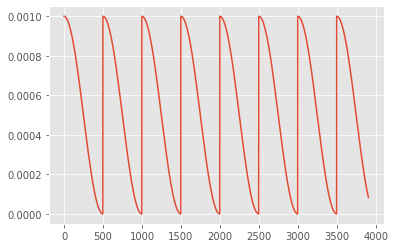

In [ ]:
lrs = []
for i in range(len(train_dl)):
    scheduler.step()
    lrs.append(
        optimizer.param_groups[0]["lr"]
    )

plt.plot(lrs)

In [ ]:
def train_one_batch(data, model, optimizer, criterion):
    model.train()
    data = [p.to(device) for p in data]
    
    optimizer.zero_grad()
    out = model(data[:-1])
    
    loss = criterion(out, data[-1]) 

    loss.backward()
    optimizer.step()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    return loss.item()

#@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    data = [p.to(device) for p in data]

    out = model(data[:-1])
    
    loss = criterion(out, data[-1])
    
    return loss.item()

In [ ]:
import time
epochs = 3
print_freq = 300

for epoch in range(1, epochs+1):

    train_loss = []
    for step, batch in enumerate(train_dl, 1):
        time_1 = time.time()
        
        loss = train_one_batch(batch, model, optimizer, criterion)
        scheduler.step()  # cooment if not cosine scheduler

        train_loss.append(loss)
        
        if step % print_freq == 0:
            print('epoch:', epoch, 
                  '\tstep:', step, '/', len(train_dl),
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')
    
    valid_loss, valid_accs = [], []
    for step, batch in enumerate(tqdm(valid_dl)):
        loss = validate_one_batch(batch, model, criterion)
        
        valid_loss.append(loss)
        
    print('epoch:', epoch, '/', epochs+1,
          '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
          '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)))
        
    stopper(np.mean(valid_loss), model)
    # scheduler.step(np.mean(valid_loss))

In [ ]:
valid_loss, valid_accs = [], []
for step, batch in enumerate(tqdm(valid_dl)):
    loss = validate_one_batch(batch, model, criterion)
    
    valid_loss.append(loss)
    
print('epoch:', epoch, '/', epochs+1,
        '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
        '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)))

100%|██████████| 391/391 [02:33<00:00,  2.55it/s]

epoch: 1 / 4 	train loss: 0.2815 	valid loss: 0.2621


$RSMLE = \sqrt{\frac{1}{N}\cdot \sum_{i=1}^N(\log({\hat{y_i} + 1}) - (y_i + 1))^2}$

In [ ]:
class RMSLE(nn.Module):
    def __init__(self):
        super(RMSLE, self).__init__()
        self.mse = nn.MSELoss()  # 1/N * sum_N(y_pred - y_true)**2

    def forward(self, y_pred, y_true):
        # target distribution: (0, 1)
        y_pred = torch.log(y_pred + 1)
        y_true = torch.log(y_true + 1)
        loss = self.mse(y_pred, y_true)
        return torch.sqrt(loss)

In [ ]:
# test with RMSLE
metric = RMSLE()
test_preds, losses = [], []
model.eval()

#with torch.no_grad():  # transformer specifics (uncomment for first model to speedup calculations)
for i, batch in enumerate(tqdm(test_dl)):
    
    data = [p.to(device) for p in batch]
    target = data[-1]

    out = model(data[:-1])

    loss = criterion(out, target)
    mvalue = metric(out, target).item()
    losses.append(loss.item())
    test_preds.append(mvalue)

test_preds = pd.Series(data=test_preds).fillna(0.).mean()
losses = np.mean(losses)

print(f"test losses: {losses:.4f}, predictions: {test_preds:.4f}")

100%|██████████| 286/286 [01:50<00:00,  2.58it/s]

test losses: 0.2625, predictions: 0.1963


In [ ]:
# poor results: make target encoding in preprocessing steps. Vectorize text + PCA? Tune hyperparameters. Use first model with DCNN? Use binary labels and predict probabilities?

### CatBoost

In [ ]:
# better solve this task with e.g. CatBoostRegressor

In [ ]:
!pip install -qq catboost

from catboost import CatBoostRegressor, Pool 
import catboost
from sklearn.metrics import mean_squared_error, mean_squared_log_error

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
# preprocessing steps...

data = pd.read_csv("train.csv", parse_dates=["activation_date"], index_col="item_id", usecols=["item_id", "region", "user_id", "parent_category_name", "description", "price", "user_type", "param_1", "city",
                                                                                               "item_seq_number", "activation_date", "category_name", "image_top_1", "title", "deal_probability"])

cat_features = ['region', 'city', 'parent_category_name', 'category_name', 'param_1', 'user_type', 'image_top_1', 'day', 'weekday']
text_features = ['title', 'description']

data = check_duplicates_and_constants(data)
data.dropna(inplace=True)

data.drop("6df9bb4c6120", inplace=True)
for category in data.parent_category_name.unique():
    prior = (data.parent_category_name == category)
    percentile = np.percentile(data.loc[data.parent_category_name == category, "price"], 99.99)
    condition = (data.price > percentile) & prior
    data = data[~condition]

data["day"] = data.activation_date.dt.day.astype("category")
data["weekday"] = data.activation_date.dt.weekday.astype("category")

data.drop("activation_date", axis=1, inplace=True)
data["description"] = data["description"].apply(preprocessor, stop=stop)

for col in cat_features:
    data[col] = data[col].astype("str")
    
for col in text_features:
    data[col] = data[col].astype("str")

data["title_len"] = data["title"].str.len()
data["description"] = data["description"].apply(lambda x: x[:500])

data["strat"] = LabelEncoder().fit_transform(data["parent_category_name"].astype("str") + data["region"].astype("str")).astype("float")

Initial train shape: (1503424, 14)
Duplicates in train: 0
Final train shape: (1503424, 14) 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data.drop("deal_probability", axis=1), data["deal_probability"], train_size=1_100_000, stratify=data["strat"], random_state=seed)

del data; gc.collect()
x_train.drop("strat", axis=1, inplace=True)
x_test.drop("strat", axis=1, inplace=True)

x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1100000 entries, ecc5aa4bb38b to abde558ed7bc
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   user_id               1100000 non-null  object 
 1   region                1100000 non-null  object 
 2   city                  1100000 non-null  object 
 3   parent_category_name  1100000 non-null  object 
 4   category_name         1100000 non-null  object 
 5   param_1               1100000 non-null  object 
 6   title                 1100000 non-null  object 
 7   description           1100000 non-null  object 
 8   price                 1100000 non-null  float64
 9   item_seq_number       1100000 non-null  int64  
 10  user_type             1100000 non-null  object 
 11  image_top_1           1100000 non-null  object 
 12  day                   1100000 non-null  object 
 13  weekday               1100000 non-null  object 
 14  title_len             1

In [ ]:
# feature selection: l1-score, permutation, boruta-shap, boostaruta...

In [ ]:
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
city_parent_mean = x_train.groupby(["city", "parent_category_name"])["price"].mean().reset_index().rename(columns={"price": "city_parent_price"})

x_train = x_train.merge(city_parent_mean, on=["city", "parent_category_name"], how="left")
x_test = x_test.merge(city_parent_mean, on=["city", "parent_category_name"], how="left") 

x_test["city_parent_price"].fillna(x_train["city_parent_price"].mean(), inplace=True)

del city_parent_mean; gc.collect()

0

In [11]:
def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: str = None,
                          suffix: str = None,
                          ) -> pd.DataFrame:
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".lower() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

In [ ]:
aggs = {"price": ["mean", "max", "sum", "count"]}
stats = create_numerical_aggs(x_train, "user_id", aggs, "user_", "_by_price")
x_train = x_train.merge(stats, on="user_id", how="left")
x_test = x_test.merge(stats, on="user_id", how="left")

In [ ]:
x_test.loc[x_test.isna().index, "user_price_mean_by_price"] = x_test.loc[x_test.isna().index, ["user_id", "price"]].groupby("user_id")["price"].transform("mean")
x_test.loc[x_test.isna().index, "user_price_max_by_price"] = x_test.loc[x_test.isna().index, ["user_id", "price"]].groupby("user_id")["price"].transform("max")
x_test.loc[x_test.isna().index, "user_price_sum_by_price"] = x_test.loc[x_test.isna().index, ["user_id", "price"]].groupby("user_id")["price"].transform("sum")
x_test.loc[x_test.isna().index, "user_price_count_by_price"] = x_test.loc[x_test.isna().index, ["user_id", "price"]].groupby("user_id")["price"].transform("count")

In [ ]:
x_train.drop("user_id", axis=1, inplace=True)
x_test.drop("user_id", axis=1, inplace=True)

In [ ]:
import time 

params = {"learning_rate": 0.1, 
          "iterations": 3000,  # default 1000; TODO: inspect learning curve and decide number of trees then remove early stopping, depth = 6 by default
          "eval_metric": "RMSE",
          "metric_period": 200, 
          "task_type": "GPU",
          "use_best_model": True,
          "l2_leaf_reg": 30.0,  # default 3.0
          "max_bin": 255,  # default 128
          "depth": 10,  # default 6
          }

def print_scores(folds_scores, train_scores):
    print(f"Train score by each fold: {train_scores}")
    print(f"Valid score by each fold: {folds_scores}")
    print(f"Train mean score by each fold:{np.mean(train_scores):.5f} +/- {np.std(train_scores):.5f}")
    print(f"Valid mean score by each fold:{np.mean(folds_scores):.5f} +/- {np.std(folds_scores):.5f}")
    print("*" * 50)

def catboost_cross_validation(params, X, y, cv, categorical=None, textual=None, rounds=20):
    estimators, folds_scores, train_scores = [], [], []

    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        model = CatBoostRegressor(**params)
        train_pool = Pool(x_train, y_train, cat_features=categorical, text_features=textual)
        valid_pool = Pool(x_valid, y_valid, cat_features=categorical, text_features=textual)
        model.fit(
            train_pool,
            eval_set=valid_pool,
            early_stopping_rounds=rounds
        )
        train_score = catboost.CatBoost.predict(model, train_pool, prediction_type='RawFormulaVal')
        train_score = mean_squared_error(y_train, np.clip(train_score, a_min=0., a_max=1.), squared=False)

        oof_preds[valid_idx] = catboost.CatBoost.predict(model, valid_pool, prediction_type='RawFormulaVal')
        score = mean_squared_error(y_valid, np.clip(oof_preds[valid_idx], a_min=0., a_max=1.), squared=False)
        folds_scores.append(round(score, 5))
        train_scores.append(round(train_score, 5))
        print(f"Fold {fold + 1}, Train score = {train_score:.5f}, Valid score = {score:.5f}")
        estimators.append(model)

    print_scores(folds_scores, train_scores)
    print(f"OOF-score (log): {mean_squared_log_error(y, np.clip(oof_preds, a_min=0., a_max=1.), squared=False):.5f}", \
          f"OOF-score (rmse): {mean_squared_error(y, np.clip(oof_preds, a_min=0., a_max=1.), squared=False):.5f}")
    return estimators, oof_preds

In [ ]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             squared=False,
                             n_samples: int = 1000):
    scores = []
    y_pred = np.clip(y_pred, a_min=0., a_max=1.)
    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true, n_samples)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap, squared=squared)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95):
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [ ]:
estimators, oof_preds = catboost_cross_validation(params, 
                                                  x_train, 
                                                  y_train,
                                                  categorical=cat_features,
                                                  textual=text_features,
                                                  cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                  rounds=20)
gc.collect()

Thu Dec  1 20:46:08 2022, Cross-Validation, 1100000 rows, 19 cols
0:	learn: 0.2582479	test: 0.2570379	best: 0.2570379 (0)	total: 328ms	remaining: 16m 24s
200:	learn: 0.2278390	test: 0.2271076	best: 0.2271076 (200)	total: 25.1s	remaining: 5m 49s
400:	learn: 0.2258904	test: 0.2258787	best: 0.2258787 (400)	total: 46s	remaining: 4m 58s
600:	learn: 0.2245655	test: 0.2252094	best: 0.2252094 (600)	total: 1m 6s	remaining: 4m 25s
800:	learn: 0.2234734	test: 0.2247527	best: 0.2247527 (800)	total: 1m 28s	remaining: 4m 2s
1000:	learn: 0.2225622	test: 0.2244502	best: 0.2244502 (1000)	total: 1m 49s	remaining: 3m 38s
1200:	learn: 0.2217069	test: 0.2242136	best: 0.2242136 (1200)	total: 2m 11s	remaining: 3m 17s
1400:	learn: 0.2209188	test: 0.2240235	best: 0.2240235 (1400)	total: 2m 33s	remaining: 2m 55s
1600:	learn: 0.2202006	test: 0.2238581	best: 0.2238581 (1600)	total: 2m 57s	remaining: 2m 35s
1800:	learn: 0.2194677	test: 0.2237081	best: 0.2237081 (1800)	total: 3m 19s	remaining: 2m 12s
2000:	learn: 0

0

In [ ]:
params = {"learning_rate": 0.1, 
          "iterations": 5000,
          "task_type": "GPU",
          "l2_leaf_reg": 30.0,  
          "max_bin": 255, 
          "metric_period": 300,
          "depth": 10,
          }

train_pool = Pool(x_train, y_train, cat_features=cat_features, text_features=text_features)
model = CatBoostRegressor(**params).fit(train_pool)

0:	learn: 0.2580219	total: 435ms	remaining: 36m 12s
300:	learn: 0.2265462	total: 45.6s	remaining: 11m 51s
600:	learn: 0.2243945	total: 1m 23s	remaining: 10m 8s
900:	learn: 0.2228289	total: 2m 6s	remaining: 9m 35s
1200:	learn: 0.2216404	total: 2m 46s	remaining: 8m 46s
1500:	learn: 0.2205559	total: 3m 27s	remaining: 8m 2s
1800:	learn: 0.2195284	total: 4m 9s	remaining: 7m 23s
2100:	learn: 0.2185924	total: 4m 50s	remaining: 6m 41s
2400:	learn: 0.2177285	total: 5m 31s	remaining: 5m 58s
2700:	learn: 0.2169456	total: 6m 13s	remaining: 5m 17s
3000:	learn: 0.2161512	total: 6m 56s	remaining: 4m 37s
3300:	learn: 0.2153899	total: 7m 36s	remaining: 3m 55s
3600:	learn: 0.2146795	total: 8m 15s	remaining: 3m 12s
3900:	learn: 0.2139913	total: 8m 55s	remaining: 2m 30s
4200:	learn: 0.2132987	total: 9m 37s	remaining: 1m 49s
4500:	learn: 0.2126171	total: 10m 20s	remaining: 1m 8s
4800:	learn: 0.2119521	total: 11m 4s	remaining: 27.5s
4999:	learn: 0.2115162	total: 11m 31s	remaining: 0us


In [ ]:
# another way is to use CatBoostClassifier with cross entropy loss with binary target
# to obtain deal probability apply predict_proba on raw predictions

In [ ]:
# holdout check rmsle + CI
indices = np.random.choice(np.arange(len(x_train)), size=100_000)

calculate_confidence_interval(create_bootstrap_metrics(y_train[indices], oof_preds[indices], mean_squared_log_error, n_samples=2000))

(0.16646074189760987, 0.16845282445229262)

In [ ]:
indices = np.random.choice(np.arange(len(x_train)), size=100_000)

calculate_confidence_interval(create_bootstrap_metrics(y_train[indices], oof_preds[indices], mean_squared_error, n_samples=2000))

(0.22352427899894586, 0.2266035767876454)

In [ ]:
# predict: blending

test_preds = np.array([catboost.CatBoost.predict(estimator, x_test, prediction_type='RawFormulaVal') for estimator in estimators]).T
test_preds = np.average(test_preds, axis=1)

mean_squared_log_error(y_test, np.clip(test_preds, 0, 1), squared=False), mean_squared_error(y_test, np.clip(test_preds, 0, 1), squared=False)

(0.16734685920239242, 0.2241590244726029)

In [ ]:
# full
test_preds = catboost.CatBoost.predict(model, x_test, prediction_type='RawFormulaVal')

mean_squared_log_error(y_test, np.clip(test_preds, 0, 1), squared=False), mean_squared_error(y_test, np.clip(test_preds, 0, 1), squared=False)

(0.16710225005477108, 0.22382981016062448)

In [ ]:
gc.collect()

0

### TabNet Pytorch implementation

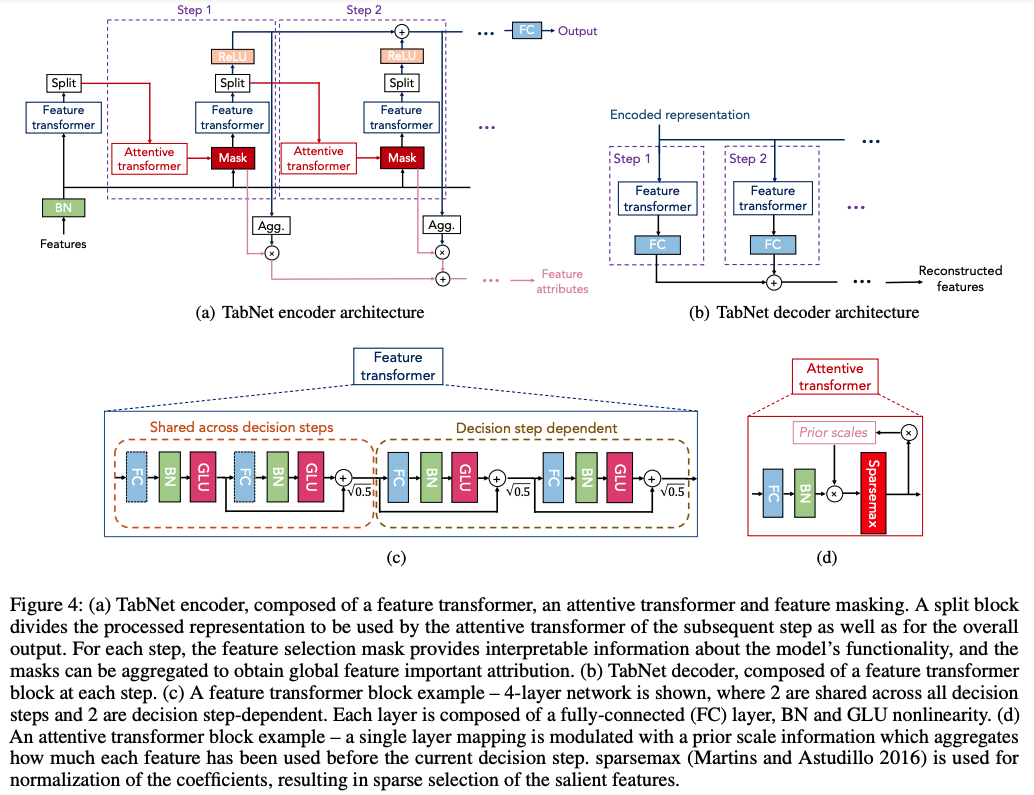

In [7]:
!pip install -qq pytorch-tabnet annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.4/647.4 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchdata 0.6.0 requires torch==

In [8]:
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.augmentations import RegressionSMOTE
from pytorch_tabnet.pretraining import TabNetPretrainer

from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# drop text column for simplicity

x_train.drop("description", axis=1, inplace=True)
x_valid.drop("description", axis=1, inplace=True)
x_test.drop("description", axis=1, inplace=True)

In [ ]:
x_train, y_train = x_train.drop("deal_probability", axis=1), x_train["deal_probability"]
x_valid, y_valid = x_valid.drop("deal_probability", axis=1), x_valid["deal_probability"]
x_test, y_test = x_test.drop("deal_probability", axis=1), x_test["deal_probability"]

In [ ]:
x_train.head()

,region,city,parent_category_name,param_1,price,item_seq_number,image_top_1,day,weekday,user_type_Private,user_type_Shop,city_parent_price
0,8,632,8,158,-0.1082,-0.1323,1.1086,20,0,1,0,-0.2938
1,13,1075,4,103,-0.1075,-0.1403,-1.1667,15,2,1,0,-0.2969
2,21,454,0,40,-0.1080,-0.1385,1.8939,19,6,1,0,-0.2945
3,9,709,4,103,-0.1081,-0.1365,-1.1378,16,3,1,0,-0.2953
4,10,728,4,124,-0.1070,-0.1223,-0.6728,23,3,1,0,-0.2967


In [ ]:
total = pd.concat([x_train, x_valid, x_test], axis=0)

In [ ]:
features = [col for col in x_train.columns]
categorical_columns = [col for col in x_train.columns if col not in columns_to_scale]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [total[col].nunique() for col in categorical_columns]

cat_emb_dim = [16, 32, 10, 24, 8, 6, 4, 4]

In [ ]:
cat_dims = [dim + 100 for dim in cat_dims]  # some internal embedding size missmatch...
cat_dims

[128, 1792, 109, 461, 119, 107, 102, 102]

In [ ]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

In [ ]:
aug = RegressionSMOTE(p=0.2)

In [ ]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [ ]:
x_train, x_valid, x_test = x_train.values, x_valid.values, x_test.values
y_train, y_valid, y_test = y_train.values.reshape(-1,1), y_valid.values.reshape(-1,1), y_test.values.reshape(-1,1)

In [ ]:
clf.fit(
    X_train=x_train, 
    y_train=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'rmse'],
    max_epochs=max_epochs,
    patience=20,
    batch_size=256,
    virtual_batch_size=32,
    # num_workers=0,
    drop_last=False,
    augmentations=aug,
) 

epoch 0  | loss: 0.05939 | train_rmsle: 0.03213 | train_rmse: 0.24063 | valid_rmsle: 0.03215 | valid_rmse: 0.24056 |  0:04:06s
epoch 1  | loss: 0.05602 | train_rmsle: 0.03258 | train_rmse: 0.24104 | valid_rmsle: 0.03257 | valid_rmse: 0.24088 |  0:08:05s
epoch 2  | loss: 0.05613 | train_rmsle: 0.03225 | train_rmse: 0.24062 | valid_rmsle: 0.03227 | valid_rmse: 0.24054 |  0:11:59s
epoch 3  | loss: 0.05593 | train_rmsle: 0.03196 | train_rmse: 0.24149 | valid_rmsle: 0.03199 | valid_rmse: 0.24147 |  0:15:40s
epoch 4  | loss: 0.05584 | train_rmsle: 0.03174 | train_rmse: 0.24032 | valid_rmsle: 0.03176 | valid_rmse: 0.24027 |  0:19:22s


KeyboardInterrupt: ignored

In [ ]:
preds = clf.predict(x_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true, squared=False)

print(f"FINAL TEST SCORE FOR test: {test_score}")

FINAL TEST SCORE FOR test: 0.24114469842380204


In [ ]:
explain_matrix, masks = clf.explain(x_test)

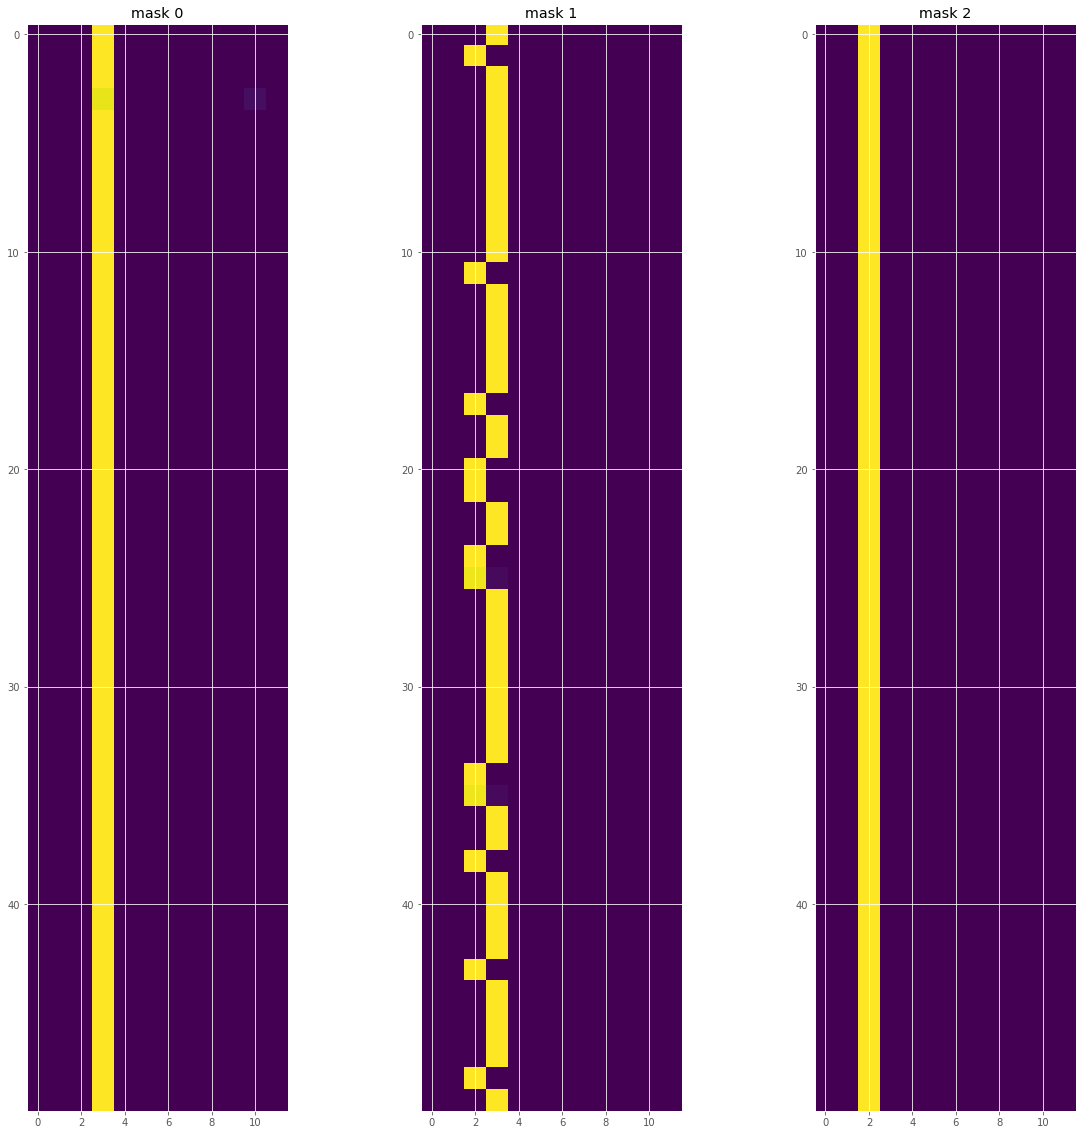

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

## TabNet + Annoy user embeddings

In [9]:
import annoy

In [12]:
data = pd.read_csv("train.csv", parse_dates=["activation_date"], index_col="item_id", usecols=["item_id", "region", "user_id", "parent_category_name", "price", 
                                                                                               "user_type", "param_1", "city", "item_seq_number", "activation_date",
                                                                                               "image_top_1",  "deal_probability"])

data = check_duplicates_and_constants(data)
data.dropna(inplace=True)

data.drop("6df9bb4c6120", inplace=True)

for category in data.parent_category_name.unique():
    prior = (data.parent_category_name == category)
    percentile = np.percentile(data.loc[data.parent_category_name == category, "price"], 99.99)
    condition = (data.price > percentile) & prior  
    data = data[~condition]

data["day"] = data.activation_date.dt.day.astype("category")
data["weekday"] = data.activation_date.dt.weekday.astype("category")
data.drop("activation_date", axis=1, inplace=True)

categorical_columns = ["region", "param_1", "city", "parent_category_name", "weekday", "day"]

categorical_dims =  {}
for col in categorical_columns:
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col].values)
    categorical_dims[col] = len(encoder.classes_)

data = pd.get_dummies(data, columns=["user_type"], drop_first=False)

data["strat"] = LabelEncoder().fit_transform(data["parent_category_name"].astype("str") + data["region"].astype("str")).astype("float")

x_train, x_valid = train_test_split(data, train_size=1_000_000, stratify=data["strat"], random_state=seed)
x_valid, x_test = train_test_split(x_valid, train_size=100_000, stratify=x_valid["strat"], random_state=seed)

x_train.drop("strat", axis=1, inplace=True)
x_valid.drop("strat", axis=1, inplace=True)
x_test.drop("strat", axis=1, inplace=True)

aggs = {"price": ["mean", "max", "sum", "count"]}
stats = create_numerical_aggs(x_train, "user_id", aggs, "user_", "_by_price")
x_train = x_train.merge(stats, on="user_id", how="left")
x_valid = x_valid.merge(stats, on="user_id", how="left")
x_test = x_test.merge(stats, on="user_id", how="left")

x_valid.loc[x_valid.isna().index, "user_price_mean_by_price"] = x_valid.loc[x_valid.isna().index, ["user_id", "price"]].groupby("user_id")["price"].transform("mean")
x_valid.loc[x_valid.isna().index, "user_price_max_by_price"] = x_valid.loc[x_valid.isna().index, ["user_id", "price"]].groupby("user_id")["price"].transform("max")
x_valid.loc[x_valid.isna().index, "user_price_sum_by_price"] = x_valid.loc[x_valid.isna().index, ["user_id", "price"]].groupby("user_id")["price"].transform("sum")
x_valid.loc[x_valid.isna().index, "user_price_count_by_price"] = x_valid.loc[x_valid.isna().index, ["user_id", "price"]].groupby("user_id")["price"].transform("count")

x_test.loc[x_test.isna().index, "user_price_mean_by_price"] = x_test.loc[x_test.isna().index, ["user_id", "price"]].groupby("user_id")["price"].transform("mean")
x_test.loc[x_test.isna().index, "user_price_max_by_price"] = x_test.loc[x_test.isna().index, ["user_id", "price"]].groupby("user_id")["price"].transform("max")
x_test.loc[x_test.isna().index, "user_price_sum_by_price"] = x_test.loc[x_test.isna().index, ["user_id", "price"]].groupby("user_id")["price"].transform("sum")
x_test.loc[x_test.isna().index, "user_price_count_by_price"] = x_test.loc[x_test.isna().index, ["user_id", "price"]].groupby("user_id")["price"].transform("count")

x_train.drop("user_id", axis=1, inplace=True)
x_valid.drop("user_id", axis=1, inplace=True)
x_test.drop("user_id", axis=1, inplace=True)

x_train, y_train = x_train.drop("deal_probability", axis=1), x_train["deal_probability"]
x_valid, y_valid = x_valid.drop("deal_probability", axis=1), x_valid["deal_probability"]
x_test, y_test = x_test.drop("deal_probability", axis=1), x_test["deal_probability"]

x_train.shape, x_valid.shape, x_test.shape

Initial train shape: (1503424, 11)
Duplicates in train: 0
Final train shape: (1503424, 11) 

((1000000, 16), (100000, 16), (180180, 16))

In [13]:
total = pd.concat([x_train, x_valid, x_test], axis=0)

In [14]:
features = [col for col in total.columns]

numerical_columns = [col for col in features if col not in categorical_columns]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

cat_emb_dim = [16, 32, 10, 24, 8, 6]

cat_dims

[28, 1696, 9, 362, 19, 7]

In [15]:
for col in numerical_columns:
    mean, std = x_train[col].mean(), x_train[col].std() * 2  # when having one-hot columns multiply std by 2
    x_train[col] = (x_train[col] - mean) / std  # std is nonzero, otherwise the feature is constant
    x_valid[col] = (x_valid[col] - mean) / std
    x_test[col] = (x_test[col] - mean) / std

In [16]:
x_train.head()

,region,city,parent_category_name,param_1,price,item_seq_number,image_top_1,day,weekday,user_type_Company,user_type_Private,user_type_Shop,user_price_mean_by_price,user_price_max_by_price,user_price_sum_by_price,user_price_count_by_price
0,9,709,0,247,-0.0515,0.3567,0.8148,9,1,-0.2711,-0.7971,2.0698,-0.0727,-0.0440,-0.0378,0.2708
1,16,594,6,91,0.0231,-0.0680,-0.0703,5,4,-0.2711,0.3136,-0.1208,0.0331,-0.0309,-0.0376,-0.1072
2,2,136,4,103,-0.0519,-0.0656,-0.5722,16,1,-0.2711,0.3136,-0.1208,-0.0744,-0.0455,-0.0384,-0.0369
3,9,400,0,24,-0.0518,-0.0671,0.9026,16,1,-0.2711,0.3136,-0.1208,-0.0743,-0.0455,-0.0385,-0.1072
4,17,1272,8,112,-0.0498,-0.0675,0.6707,15,0,-0.2711,0.3136,-0.1208,-0.0713,-0.0451,-0.0384,-0.1072


In [55]:
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',
    n_shared_decoder=1, 
    n_indep_decoder=1, 
    verbose=5,
)

In [56]:
unsupervised_model.fit(
    X_train=x_train.values,
    eval_set=[x_valid.values],
    max_epochs=100,
    patience=5,
    batch_size=1024, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
    warm_start=True,
) 

epoch 0  | loss: 0.81308 | val_0_unsup_loss_numpy: 1.3766599893569946|  0:01:07s
epoch 5  | loss: 0.5394  | val_0_unsup_loss_numpy: 5.86407995223999|  0:05:33s

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_unsup_loss_numpy = 1.2394100427627563


In [57]:
reconstructed_X, embedded_Xtrain = unsupervised_model.predict(x_train.values)

In [60]:
deal_index = annoy.AnnoyIndex(16, "angular")

for i in range(len(x_train)):
    deal_index.add_item(i, embedded_Xtrain[i])

    if i > 1_000_000:
        break

deal_index.build(20) 

True

In [61]:
def get_similar(raw, index, df, model, topk=5):
    _, vector = model.predict(raw.values[None, :])
    similar_deal_indexes = index.get_nns_by_vector(vector.squeeze(), topk)
    return df.iloc[similar_deal_indexes]

In [62]:
x_test.iloc[5], y_test.iloc[5]

(region                        27.0000
 city                        1687.0000
 parent_category_name           2.0000
 param_1                      106.0000
 price                         -0.0511
 item_seq_number               -0.0661
 image_top_1                    0.3150
 day                           15.0000
 weekday                        0.0000
 user_type_Company             -0.2711
 user_type_Private              0.3136
 user_type_Shop                -0.1208
 user_price_mean_by_price      -0.0732
 user_price_max_by_price       -0.0453
 user_price_sum_by_price       -0.0384
 user_price_count_by_price     -0.1072
 Name: 5, dtype: float64,
 0.86521)

In [63]:
get_similar(x_test.iloc[5], deal_index, x_train, unsupervised_model)

,region,city,parent_category_name,param_1,price,item_seq_number,image_top_1,day,weekday,user_type_Company,user_type_Private,user_type_Shop,user_price_mean_by_price,user_price_max_by_price,user_price_sum_by_price,user_price_count_by_price
982656,27,1687,2,106,-0.0516,-0.0680,0.3160,15,0,-0.2711,0.3136,-0.1208,-0.0739,-0.0454,-0.0385,-0.1072
7326,27,1687,2,106,-0.0520,-0.0669,0.3175,15,0,-0.2711,0.3136,-0.1208,-0.0745,-0.0455,-0.0385,-0.1072
700019,27,1687,2,106,-0.0520,-0.0659,0.3051,15,0,-0.2711,0.3136,-0.1208,-0.0744,-0.0455,-0.0385,-0.1072
651125,27,1687,2,106,-0.0486,-0.0680,0.3113,8,0,-0.2711,0.3136,-0.1208,-0.0697,-0.0448,-0.0384,-0.1072
259114,27,1687,2,106,-0.0509,-0.0680,0.3253,15,0,-0.2711,0.3136,-0.1208,-0.0729,-0.0453,-0.0384,-0.1072


In [64]:
idxs = get_similar(x_test.iloc[5], deal_index, x_train, unsupervised_model).index
y_train.loc[idxs]

982656   0.8652
7326     0.8652
700019   0.8652
651125   0.0000
259114   0.0000
Name: deal_probability, dtype: float64